# Animal Classifier

## Loading Deps
Which are provided by tensorpad?

In [1]:
# Allows access to the file system
import os

# Provides an API for scientific computing
import numpy as np

# Allows us to render images and plot data
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import math
import matplotlib.pyplot as plt

# Machine learning framework that provides an abstract API on top of Tensorflow
import keras
from keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint, TensorBoard
from keras.layers import Activation, Conv2D, Dense, Flatten, MaxPooling2D
from keras.models import Sequential
from keras import optimizers

# Allows use to timestamp the training run
from datetime import datetime

Using TensorFlow backend.


## Load dataset
- How to mount dataset
- Directory
- Y = classes
- X = image paths

In [2]:
def get_class_labels(dir):
    """
    Gets the name of each directory in the directory.
    
    dir: Directory which holds directories.
    return: An array of the names of the directories in dir.
    """
    
    # Get all directories in this directory
    classes = os.listdir(dir)
    
    return classes

In [3]:
def get_class_images(classes, dir):
    """
    Gets the paths of all images in each directory.
    
    classes: Name of each class.
    dir: Directory which holds directories.
    return: A 2d array of paths organized by class name.
    """
    
    # Create an array to hold the image paths of each class
    class_paths = []

    # Create image paths of each class
    for label in classes:
        
        # Create an array to hold the image paths of this class (label)
        image_paths = np.array([])

        # Create the path of this class
        class_path = os.path.join(dir, label)

        # Get all images in this directory
        images = os.listdir(class_path)

        # Create the path of each images in this class
        for image in images:
            
            # Create the path of this image
            image_path = os.path.join(class_path, image)

            # Add the image path to the image paths array
            image_paths = np.append(image_paths, image_path)

        # Add the image paths to the class paths array
        class_paths.append(image_paths)
        
    return class_paths

In [4]:
# Dataset should be a set of images in a nested structure. 
# The root directory should hold them all. In the root directory should be several directories.
# Each directory should have the name of the class (cat) of images it holds.
# In each directory should be images of the same class (cat images).

# Crawl the dataset directory and create an array for y, image labels (directory name), 
# and x, image (image path)
train_dir = 'dataset/train'
validate_dir = 'dataset/validate'
predict_dir = 'dataset/predict'

# Get the name of each directory in the root directory and store them as an array.
# These are the classes.
classes = get_class_labels(predict_dir)

# Get the number of classes
n_classes = len(classes)

# Get the paths of all the images in each class directory and store them as a 2d array.
# These are the class images paths.
image_paths = get_class_images(classes, predict_dir)

## Example dataset
- Diplay name of all classes
- Display at 1 image from each class 
- with class name

In [5]:
# Display the name of all the classes
print("Classes: " + str(classes))

# Display the number of classes
print("Number of classes: " + str(n_classes))

# Display some of the image paths
print("Image Paths:\n" + str(image_paths))

Classes: ['cat', 'dog', 'sheep', 'cow']
Number of classes: 4
Image Paths:
[array(['dataset/predict/cat/6.jpeg', 'dataset/predict/cat/18.jpeg'],
      dtype='<U32'), array(['dataset/predict/dog/OIP-0cYdzGqi1lvZQkk0Hy0GGAHaIu.jpeg',
       'dataset/predict/dog/OIP-0GhaPMWsyP-8rHQIiZwBOQHaJn.jpeg'],
      dtype='<U55'), array(['dataset/predict/sheep/e037b00b2af41c22d2524518b7444f92e37fe5d404b0144390f8c078a0eabd_640.jpg'],
      dtype='<U92'), array(['dataset/predict/cow/OIP-0h4l2T_792LYTbp1hSzdswHaHa.jpeg'],
      dtype='<U55')]


In [6]:
def setup_fig(h, w):
    fig = plt.figure(figsize=(h, w), tight_layout=True)
    fig.set_facecolor('white')
    return fig

In [7]:
def plot_image(cols, fig, image_path, subplot_index, subplot_label):
    """
    Loads an image from a path, then renders it to the figure with a label
    
    cols: total number of images to be plotted, if calling this many times for a figure
    fig: figure to plot the image onto
    image_path: path to the image to be plotted
    subplot_index: Index describing where in the figure the image should be plotted
    subplot_label: Label for the subplot
    """
    
    # load the image
    # pip install pillow may be required
    image_pil = load_img(image_path, interpolation='nearest', target_size=(200,200))
        
    # render an image to the plot
    ax = fig.add_subplot(1, cols, subplot_index)
    ax.imshow(image_pil)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(subplot_label)

/anaconda2/envs/ml/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


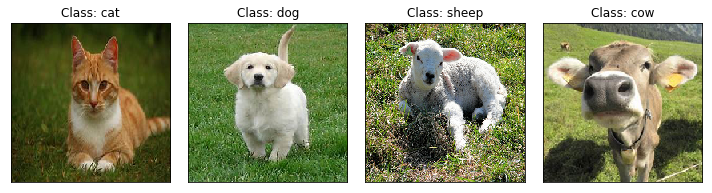

In [8]:
# Display an image from each class with the name of the class

# configure the graph which is used for rendering the images
%matplotlib inline
fig = setup_fig(10, 10)

# render the first image from each class
for index, label in enumerate(classes):
    image_path = image_paths[index][0]
    subplot_index = index+1
    subplot_label = 'Class: ' + label
    
    # plot an image
    plot_image(n_classes, fig, image_path, subplot_index, subplot_label)

## Create a model
- Use keras
- Input = image as [64x64x3]?
- Based on VVG16?
- Output = [10]
- loss
- optimizer
- compile model

In [9]:
# Hyperparameters
# the number of pixels for the width and height of the image
image_dim = 32

# the size of the image (h,w,c)
input_shape = (image_dim, image_dim, 3)

# the rate which the model learns
learning_rate = 0.0001

In [10]:
# define the model
# takes in images, convoles them, flattens them, classifies them
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=None, padding='valid'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=None, padding='valid'),
    Flatten(),
    Dense(n_classes, activation='softmax')
])

In [11]:
# define the optimizer and loss to use
model.compile(optimizer=optimizers.SGD(lr=learning_rate, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# look at the defined model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

## Train and Validate the model
- Use x epochs
- Use x batchsize
- Save model every 10 epochs
- Generate 10 predictions every 10 epochs
- Display predicted label and actual

In [13]:
# define data generators
train_data_generator = ImageDataGenerator()
validation_data_generator = ImageDataGenerator()

train_generator = train_data_generator.flow_from_directory(train_dir,
                                                          target_size=(image_dim, image_dim),
                                                          batch_size=1,
                                                          class_mode='categorical')

validation_generator = validation_data_generator.flow_from_directory(validate_dir,
                                                          target_size=(image_dim, image_dim),
                                                          batch_size=1,
                                                          class_mode='categorical')

Found 6 images belonging to 4 classes.
Found 6 images belonging to 4 classes.


In [14]:
classes_dictionary = train_generator.class_indices
print(classes_dictionary)

{'cat': 0, 'cow': 1, 'dog': 2, 'sheep': 3}


In [15]:
# directory which we will save training outputs to
# add a timestamp so that tensorboard show each training session as a different run
timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
output_logs_dir = 'logs/' + timestamp

# log information for use with tensorboard
tensorboard = TensorBoard(log_dir=output_logs_dir)

In [16]:
# directory which we will save the training checkpoints
checkpoint_name = 'checkpoint'

In [17]:
# load up previous training checkpoints if it exists
if os.path.isfile(checkpoint_name):
    model.load_weights(checkpoint_name)

In [18]:
# save the training checkpoints
checkpoint = ModelCheckpoint(checkpoint_name,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='auto',
                             period=1)

In [19]:
# stop training early
early_stopping = EarlyStopping(monitor='val_acc',
                               min_delta=0,
                               patience=10,
                               verbose=1,
                               mode='auto')

In [20]:
def prediction(image_path):
    image_pil = load_img(image_path, interpolation='nearest', target_size=(image_dim, image_dim, 3))
    image_arr = img_to_array(image_pil)

    image = np.array([image_arr])
    
    prediction = model.predict(image, batch_size=1)
    subplot_label = "Prediction: " + str(prediction)
    
    fig = setup_fig(7, 7)
    plot_image(1, fig, image_path, 1, subplot_label)

In [21]:
image_path = image_paths[0][0]


# define a callback to make a prediction
predict = LambdaCallback(on_epoch_end=lambda epoch, logs: prediction(image_path))

In [22]:
def cleanup_checkpoint():
    if os.path.isfile(checkpoint_name):
        os.remove(checkpoint_name)

# remove the checkpoint file
cleanup = LambdaCallback(on_train_end=lambda log: cleanup_checkpoint())

Epoch 1/10
1/1 [==============================] - 0s 115ms/step - loss: 16.1181 - acc: 0.0000e+00 - val_loss: 1.1292 - val_acc: 0.0000e+00

Epoch 00001: val_acc improved from -inf to 0.00000, saving model to checkpoint
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 6.7584 - acc: 0.0000e+00 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00002: val_acc improved from 0.00000 to 1.00000, saving model to checkpoint
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 16.1181 - acc: 0.0000e+00 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00003: val_acc did not improve from 1.00000
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 16.1181 - acc: 0.0000e+00 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00004: val_acc did not improve from 1.00000
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 16.1181 - acc: 0.0000e+00 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00005: val_acc did not improve from 1.0

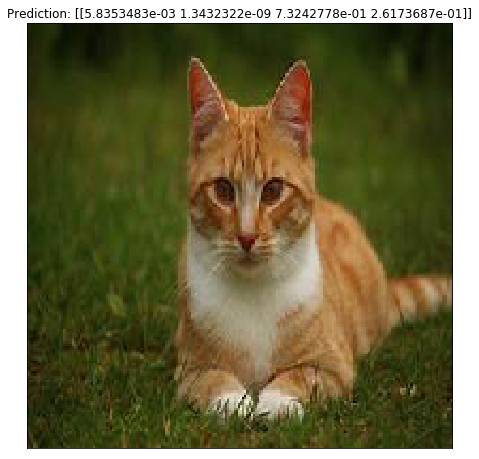

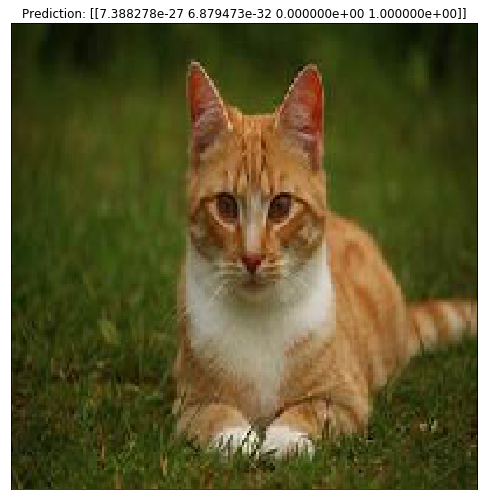

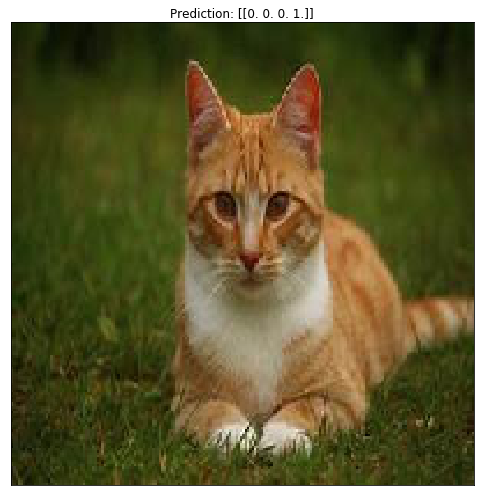

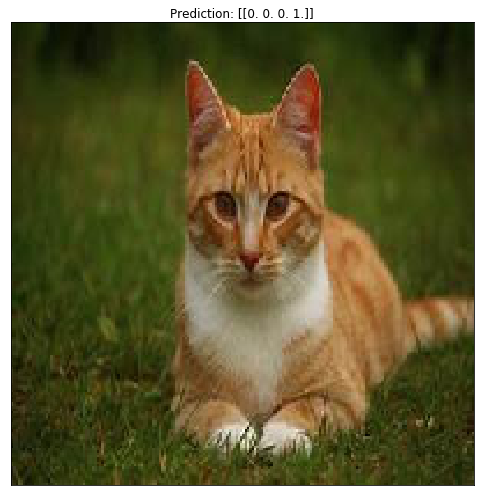

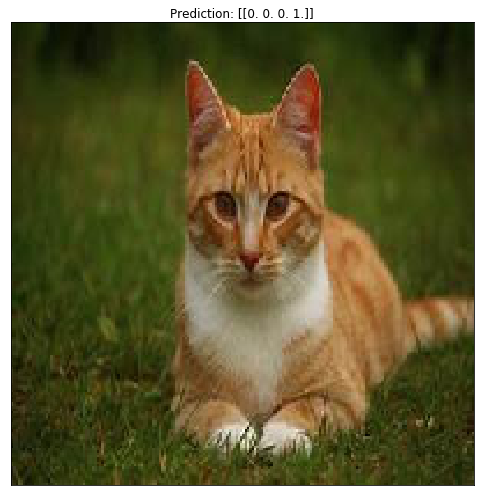

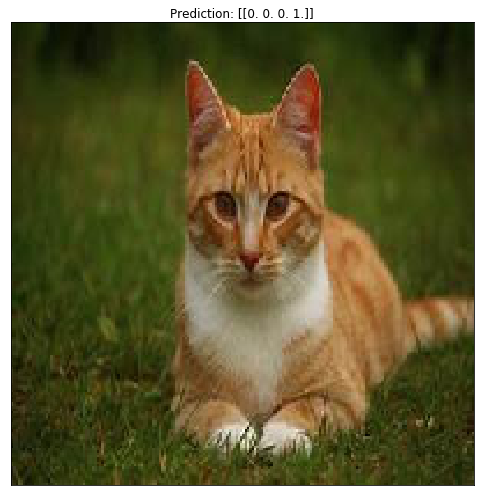

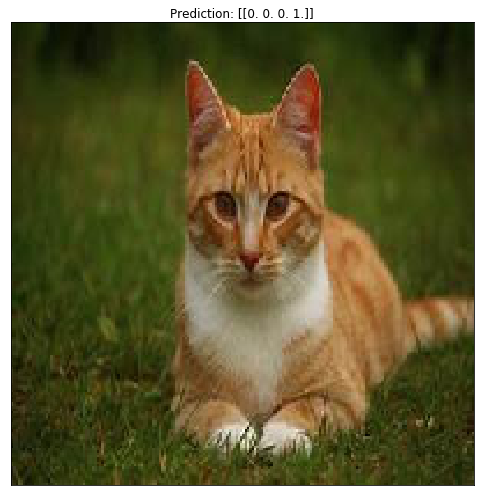

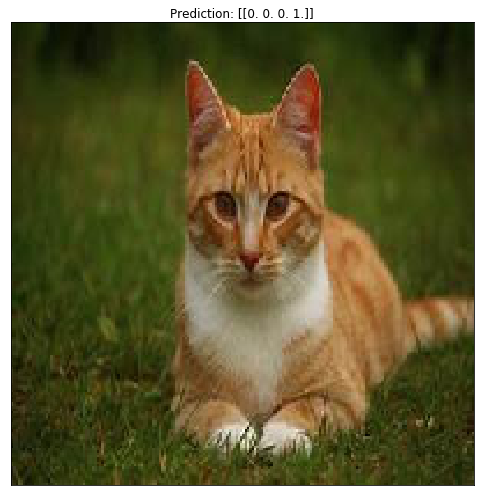

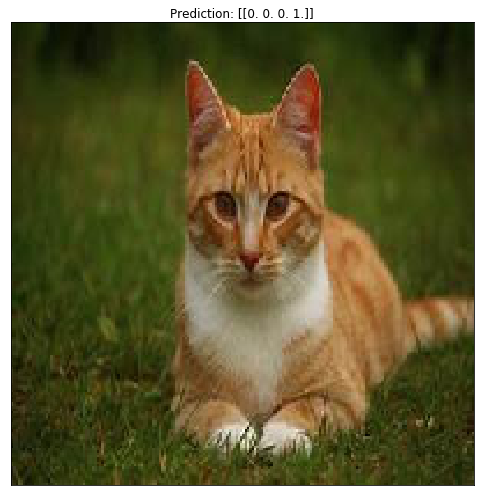

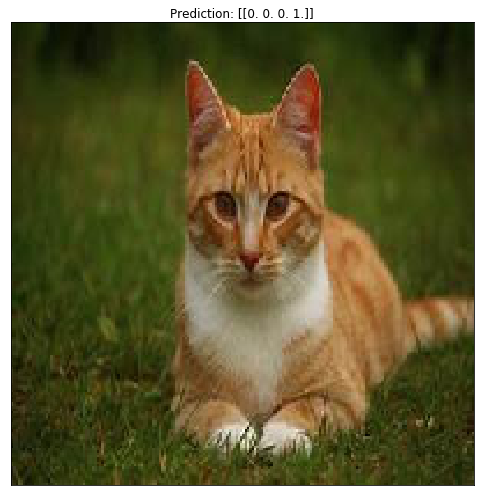

In [23]:
model.fit_generator(train_generator, 
                    steps_per_epoch=1,
                    validation_data=validation_generator,
                    validation_steps=1,
                    epochs=10,
                    callbacks=[checkpoint, cleanup, early_stopping, predict, tensorboard])

In [24]:
# view tensorboard with http://127.0.0.1:6006

In [25]:
# directory to save the model
model_name = 'trained_model'

# export the model for later
model.save(model_name)

## Predict
- Make 100 predictions
- Display predicted label, actual label, and image

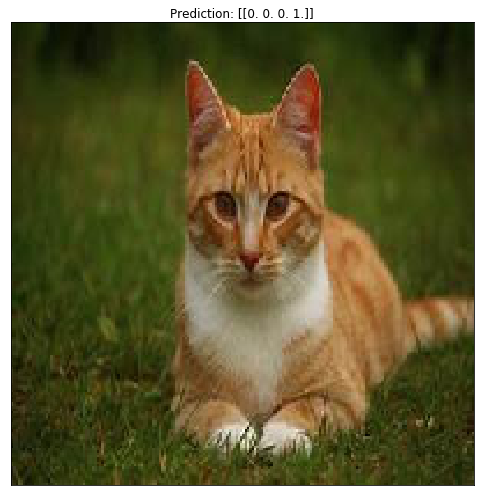

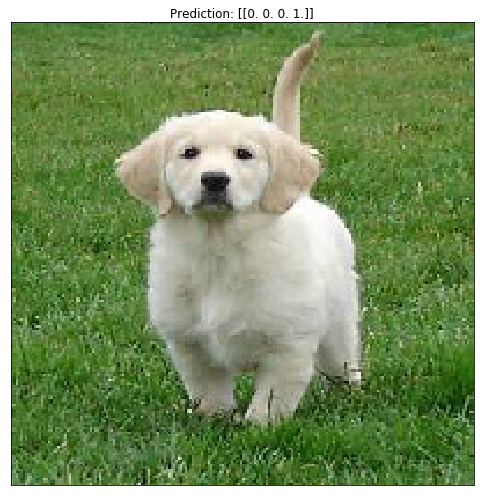

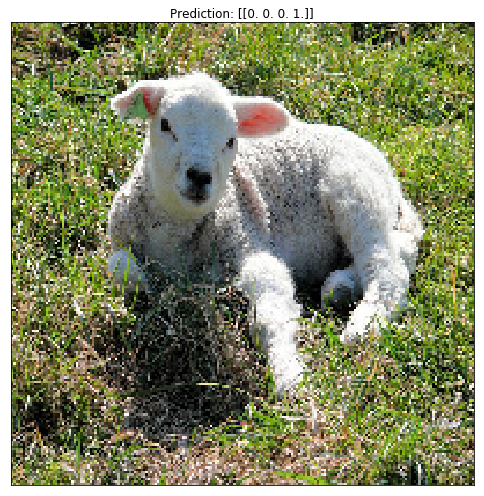

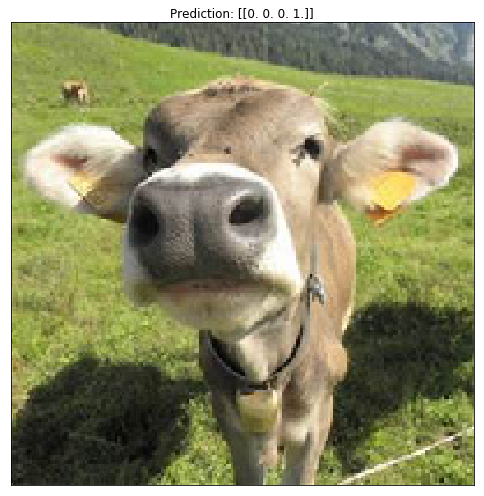

In [26]:
for image_path in image_paths:
    prediction(image_path[0])

## Benchmarks
- Training time on desktop
- Training time on colab
- Training time on tensorpad